# Imports

In [36]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import shutil
import pathlib

# Preprocessing

Based on https://www.tensorflow.org/tutorials/load_data/images

## Organizing the dataset

To load the dataset using `tf.keras.utils.image_dataset_from_directory()`, the dataset must be divided into subfolders for each label. In the case of 17 flowers, we'll have 17 folders.

The 17 labels are:

In [37]:
# list of class labels
with open("17flowers_labels.txt", "r") as f:
    labels = [line.strip() for line in f]

print(labels)

['Daffodil', 'Snowdrop', 'LilyValley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary', 'Sunflower', 'Daisy', 'ColtsFoot', 'Dandelion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']


Create the 17 subfolders:

In [38]:
# set the path to the folder containing the images
path_to_images = "data/17flowers/jpg/"
new_path_to_images = "data/17flowers/labeled/"

# create the subfolders to hold the images
for label in labels:
    os.makedirs(new_path_to_images + label, exist_ok=True)
print("All 17 subfolders created.")


All 17 subfolders created.


Copy images to their subfolders:

In [39]:
# move the images into the subfolders
image_count = 0
for filename in os.listdir(path_to_images):
    if filename.endswith(".jpg"):
        # calculate the subfolder to move the image into
        subfolder_number = image_count // 80  # 80 images per label
        subfolder_name = new_path_to_images + labels[subfolder_number]
        # move the image into the subfolder
        shutil.copy(os.path.join(path_to_images, filename), os.path.join(subfolder_name, filename))
        # increment the image count
        image_count += 1
print("Images copied successfully.")

Images copied successfully.


In [40]:
data_dir = pathlib.Path(new_path_to_images)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Number of images: {image_count}")

Number of images: 1360


## Create the training and validation datasets

Parameters for the loader:

In [41]:
batch_size = 32
img_height = 180
img_width = 180

Use `80%` of the images for training, and the remainder for validation:

In [42]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 1360 files belonging to 17 classes.
Using 1088 files for training.
Using 272 files for validation.


We also create a dataset object with both training and validation sets for fitting the final model:

In [43]:
all_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 1360 files belonging to 17 classes.


Verify class names are correct:

In [44]:
class_names = train_ds.class_names
print(class_names)

['Bluebell', 'Buttercup', 'ColtsFoot', 'Cowslip', 'Crocus', 'Daffodil', 'Daisy', 'Dandelion', 'Fritillary', 'Iris', 'LilyValley', 'Pansy', 'Snowdrop', 'Sunflower', 'Tigerlily', 'Tulip', 'Windflower']


## Visualize the data

Here are the first 9 images from the training dataset.

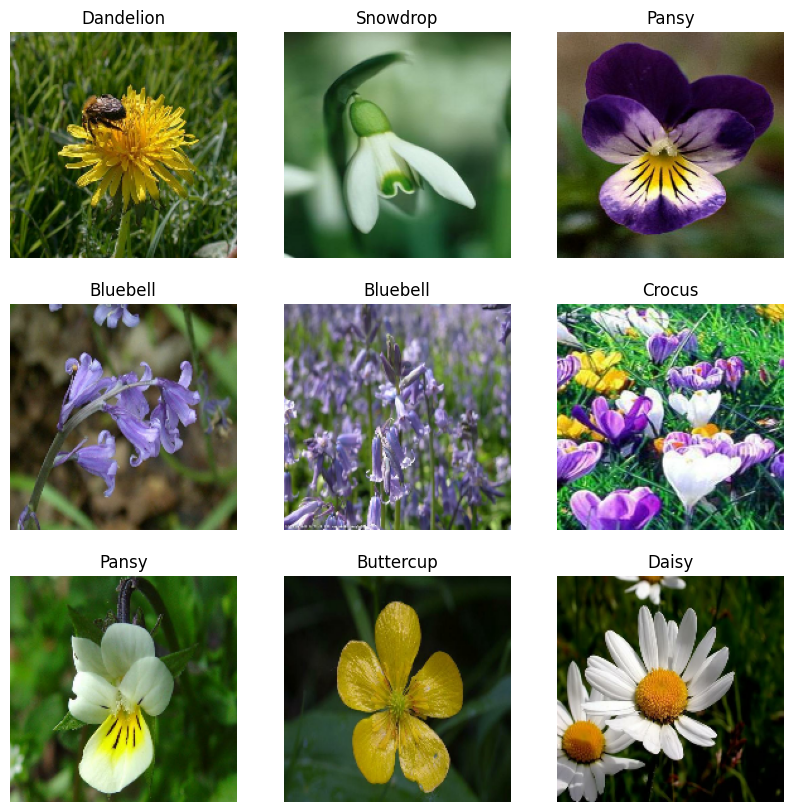

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Retrieve batches of images:

In [46]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, we will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:



In [47]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

We can either apply this layer to the dataset, or include it as part of the model definition. Here, we apply it to the dataset:

In [48]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(f"Min/max pixel values: {np.min(first_image)}, {np.max(first_image)}")

Min/max pixel values: 0.0, 1.0


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [49]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Train a CNN

## Simple model

Create a simple model to verify that the dataset is valid for training a model:

In [50]:
num_classes = 17

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(180, 180, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Train the model for a small number of `epochs` so it runs quickly:

In [51]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


c:\Git\imlex\deep-learning-project\venv\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34/34 [==============================] - 9s 245ms/step - loss: 5.0176 - accuracy: 0.1654 - val_loss: 2.3177 - val_accuracy: 0.2904
Epoch 2/3
34/34 [==============================] - 7s 218ms/step - loss: 1.4570 - accuracy: 0.6020 - val_loss: 1.6638 - val_accuracy: 0.4301
Epoch 3/3
34/34 [==============================] - 7s 214ms/step - loss: 0.4376 - accuracy: 0.9035 - val_loss: 1.7254 - val_accuracy: 0.4706


## Tune the model

We'll use `keras-tuner` to tune the model architecture and its parameters. First, we define a function to build models:

In [52]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras_tuner as kt

num_classes = 17

def build_model(hp):
  filters = hp.Int('filters', min_value=32, max_value=512, step=32)
  kernel_size = hp.Choice('kernel_size', [3, 5])
  pool_size = 2

  model = tf.keras.Sequential()
  model.add(Conv2D(
    filters=filters, 
    kernel_size=(kernel_size, kernel_size), 
    activation='relu', 
    input_shape=(180, 180, 3)))
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # from_logits=True ?
    metrics=['accuracy'])
  
  return model

Initialize the tuner:

In [53]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    directory="tuner",
    project_name="td4")

tuner.search_space_summary()

Search space summary
Default search space size: 2
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}


Start the search:

In [54]:
tuner.search(train_ds, epochs=3, validation_data=val_ds)

Trial 3 Complete [00h 03m 38s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.5514705777168274
Total elapsed time: 00h 06m 35s
INFO:tensorflow:Oracle triggered exit


Display summary of the results:

In [55]:
tuner.results_summary()

Results summary
Results in tuner\td4
Showing 10 best trials
Trial summary
Hyperparameters:
filters: 224
kernel_size: 3
Score: 0.5514705777168274
Trial summary
Hyperparameters:
filters: 320
kernel_size: 5
Score: 0.5
Trial summary
Hyperparameters:
filters: 32
kernel_size: 5
Score: 0.4889705777168274


And the best model:

In [56]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 224)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1774304)           0         
                                                                 
 dense (Dense)               (None, 17)                30163185  
                                                                 
Total params: 30,169,457
Trainable params: 30,169,457
Non-trainable params: 0
_________________________________________________________________


Now we train the model on the best hyperparameters:

In [57]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)

# Build the model with the best hp.
model = build_model(best_hps[0])

# Fit to the entire dataset
model.fit(all_ds, epochs=10)

Epoch 1/10
43/43 [==============================] - 54s 1s/step - loss: 2407.1177 - accuracy: 0.1294
Epoch 2/10
43/43 [==============================] - 53s 1s/step - loss: 2.0057 - accuracy: 0.6088
Epoch 3/10
43/43 [==============================] - 54s 1s/step - loss: 0.6073 - accuracy: 0.8640
Epoch 4/10
43/43 [==============================] - 54s 1s/step - loss: 0.2624 - accuracy: 0.9529
Epoch 5/10
43/43 [==============================] - 54s 1s/step - loss: 0.1133 - accuracy: 0.9779
Epoch 6/10
43/43 [==============================] - 53s 1s/step - loss: 0.1020 - accuracy: 0.9860
Epoch 7/10
43/43 [==============================] - 53s 1s/step - loss: 0.1032 - accuracy: 0.9875
Epoch 8/10
43/43 [==============================] - 53s 1s/step - loss: 0.0869 - accuracy: 0.9904
Epoch 9/10
43/43 [==============================] - 52s 1s/step - loss: 0.1119 - accuracy: 0.9831
Epoch 10/10
43/43 [==============================] - 53s 1s/step - loss: 0.0396 - accuracy: 0.9941
